# Most common fragments

- Find 50 most common fragments in each subpocket.
- Cluster these fragments using Butina clustering.
- Draw 50 most common fragments per subpocket sorted by descending cluster size.

In [1]:
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from util import read_fragment_library, most_common_fragments, generate_fingerprints, cluster_molecules

In [2]:
# Path to library folder
PATH_TO_LIB = Path('.') / '..' / 'data' / 'fragment_library'

## Functions

In [3]:
def _draw_clusters(mols, mols_count, clusters):
    """
    Draw fragments sorted by descending cluster size.
    
    Parameters
    ----------
    mols : list of rdkit.Chem.rdchem.Mol
        List of top x fragments.
    mols_count : pandas.Series
        Frequence of top x fragments in subpocket.
    clusters : list of tuple of integers
        List of clusters, whereby each cluster is described by its cluster member IDs.
    
    Returns
    -------
    PIL.PngImagePlugin.PngImageFile
        Image of fragments sorted by descending cluster size.
    """
    
    clustered_mols = []
    legends = []
    
    for cluster_id, cluster in enumerate(clusters):
        
        clustered_mols.extend([mols[mol_id] for mol_id in cluster])
        legends.extend([f'{cluster_id+1} | {mols_count[mol_id]}' for mol_id in cluster])
        
    img = Draw.MolsToGridImage(clustered_mols, legends=legends,  molsPerRow=6)
    
    return img

In [4]:
def main(fragment_library, subpocket, output_path=None):
    """
    
    Main function
    - gets top X (50 per default) most common fragments
    - clusters them by fingerprint similarity
    - draws/saves resulting clusters, sorted by descending cluster size (legend: cluster nr | frequency of fragment)

    Parameters
    ----------
    fragment_library : dict of pandas.DataFrame
        Fragment details (values), i.e. SMILES, kinase groups, and fragment RDKit molecules, for each subpocket (key).
    subpocket : str
        Subpocket name, i.e. AP, SE, FP, GA, B1, or B2.
    output_path : str
        Path to output folder.
        
    Returns
    -------
    
    """
    
    fragments = fragment_library[subpocket]
    
    # Get top X most common fragments
    mols, mols_count = most_common_fragments(fragments, top_x=50)

    # Generate fingerprints
    fingerprints = generate_fingerprints(mols)

    # Cluster fingerprints
    clusters = cluster_molecules(fingerprints, cutoff=0.6)

    # Draw fragments
    img = _draw_clusters(mols, mols_count, clusters)
    
    if output_path is not None:
        img.save(Path(output_path) / 'clustered_most_common_fragments_{subpocket}.png')
        
    print(type(img))
    
    return img 

## Read subpocket data

In [5]:
fragment_library = read_fragment_library(PATH_TO_LIB)

## Cluster most common fragments

### Adenine pocket

Number of fragments: 50
Threshold:  0.6
Number of clusters:  19
# clusters with only 1 compound:  10
<class 'PIL.PngImagePlugin.PngImageFile'>


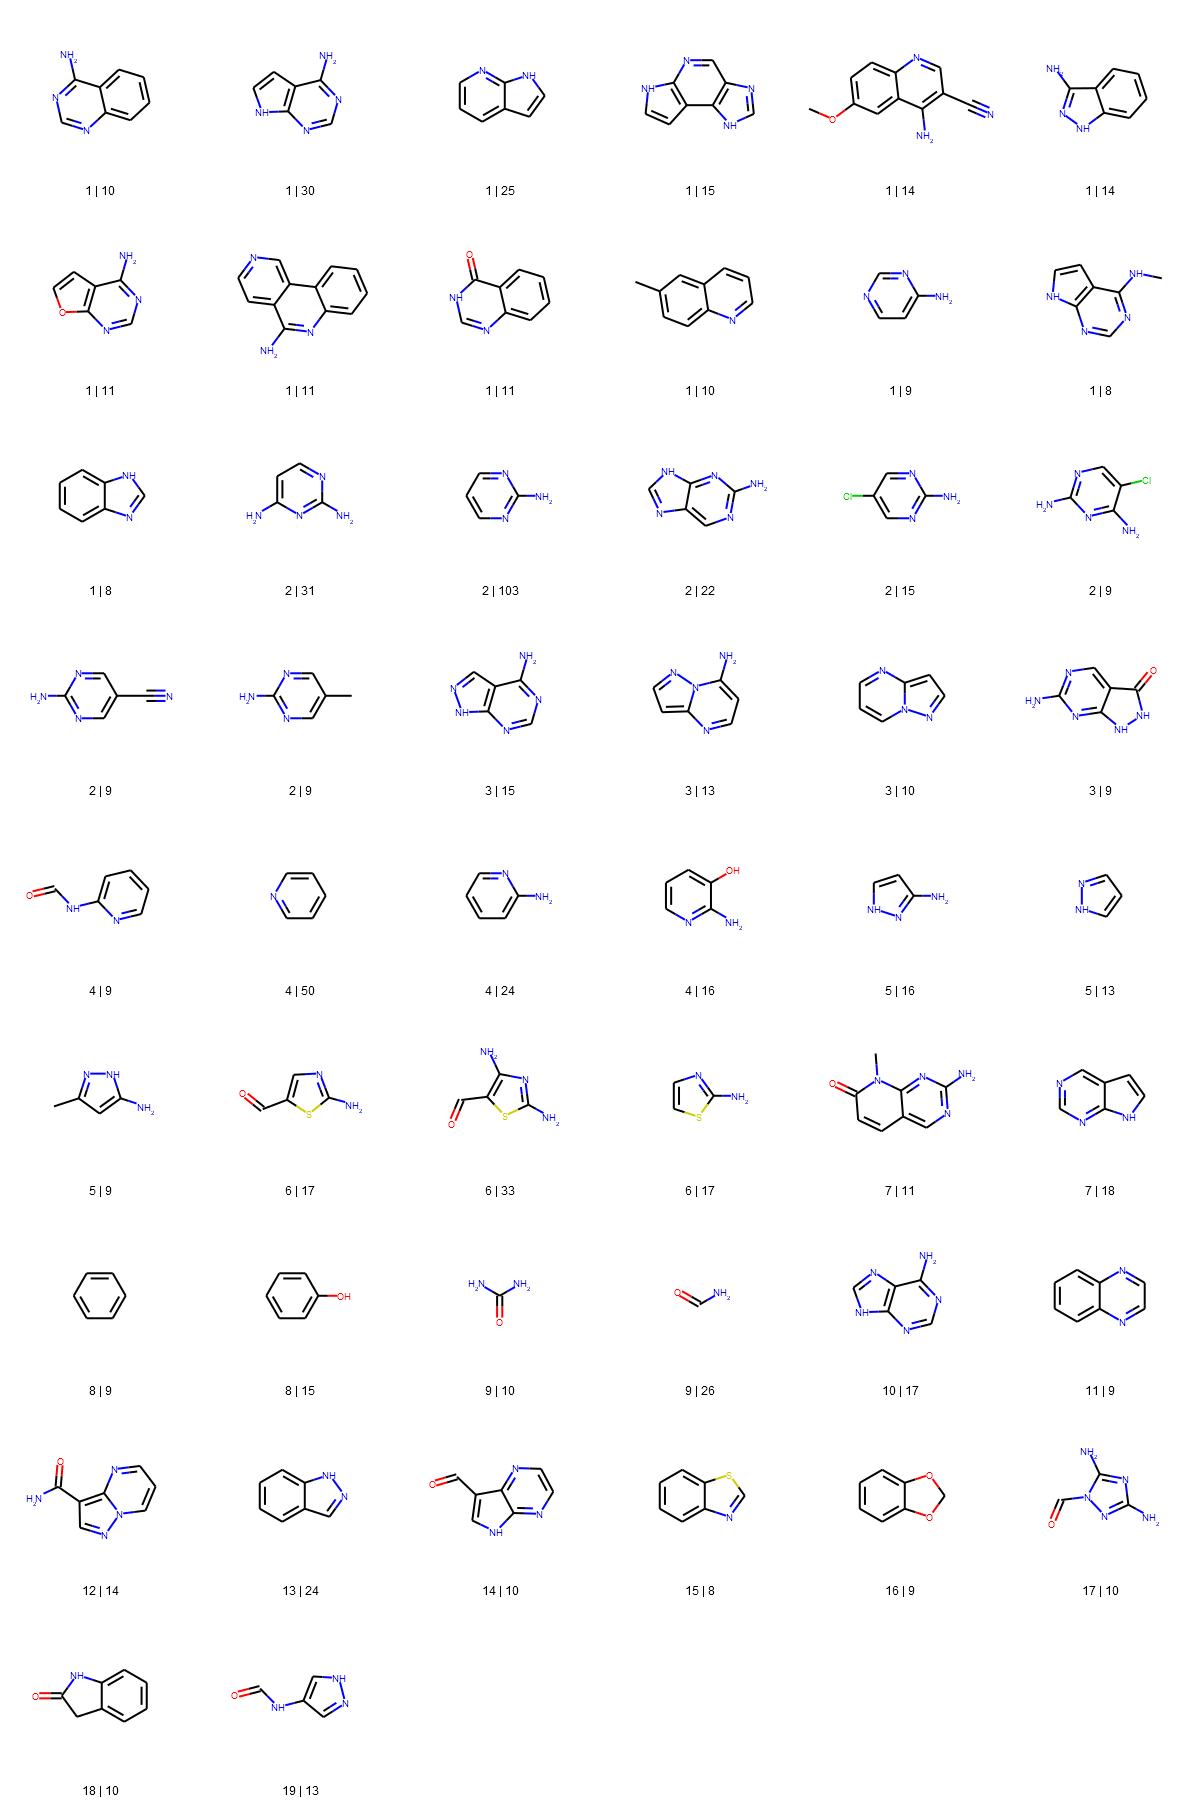

In [6]:
main(fragment_library, 'AP')

### Front pocket

Number of fragments: 50
Threshold:  0.6
Number of clusters:  23
# clusters with only 1 compound:  11
<class 'PIL.PngImagePlugin.PngImageFile'>


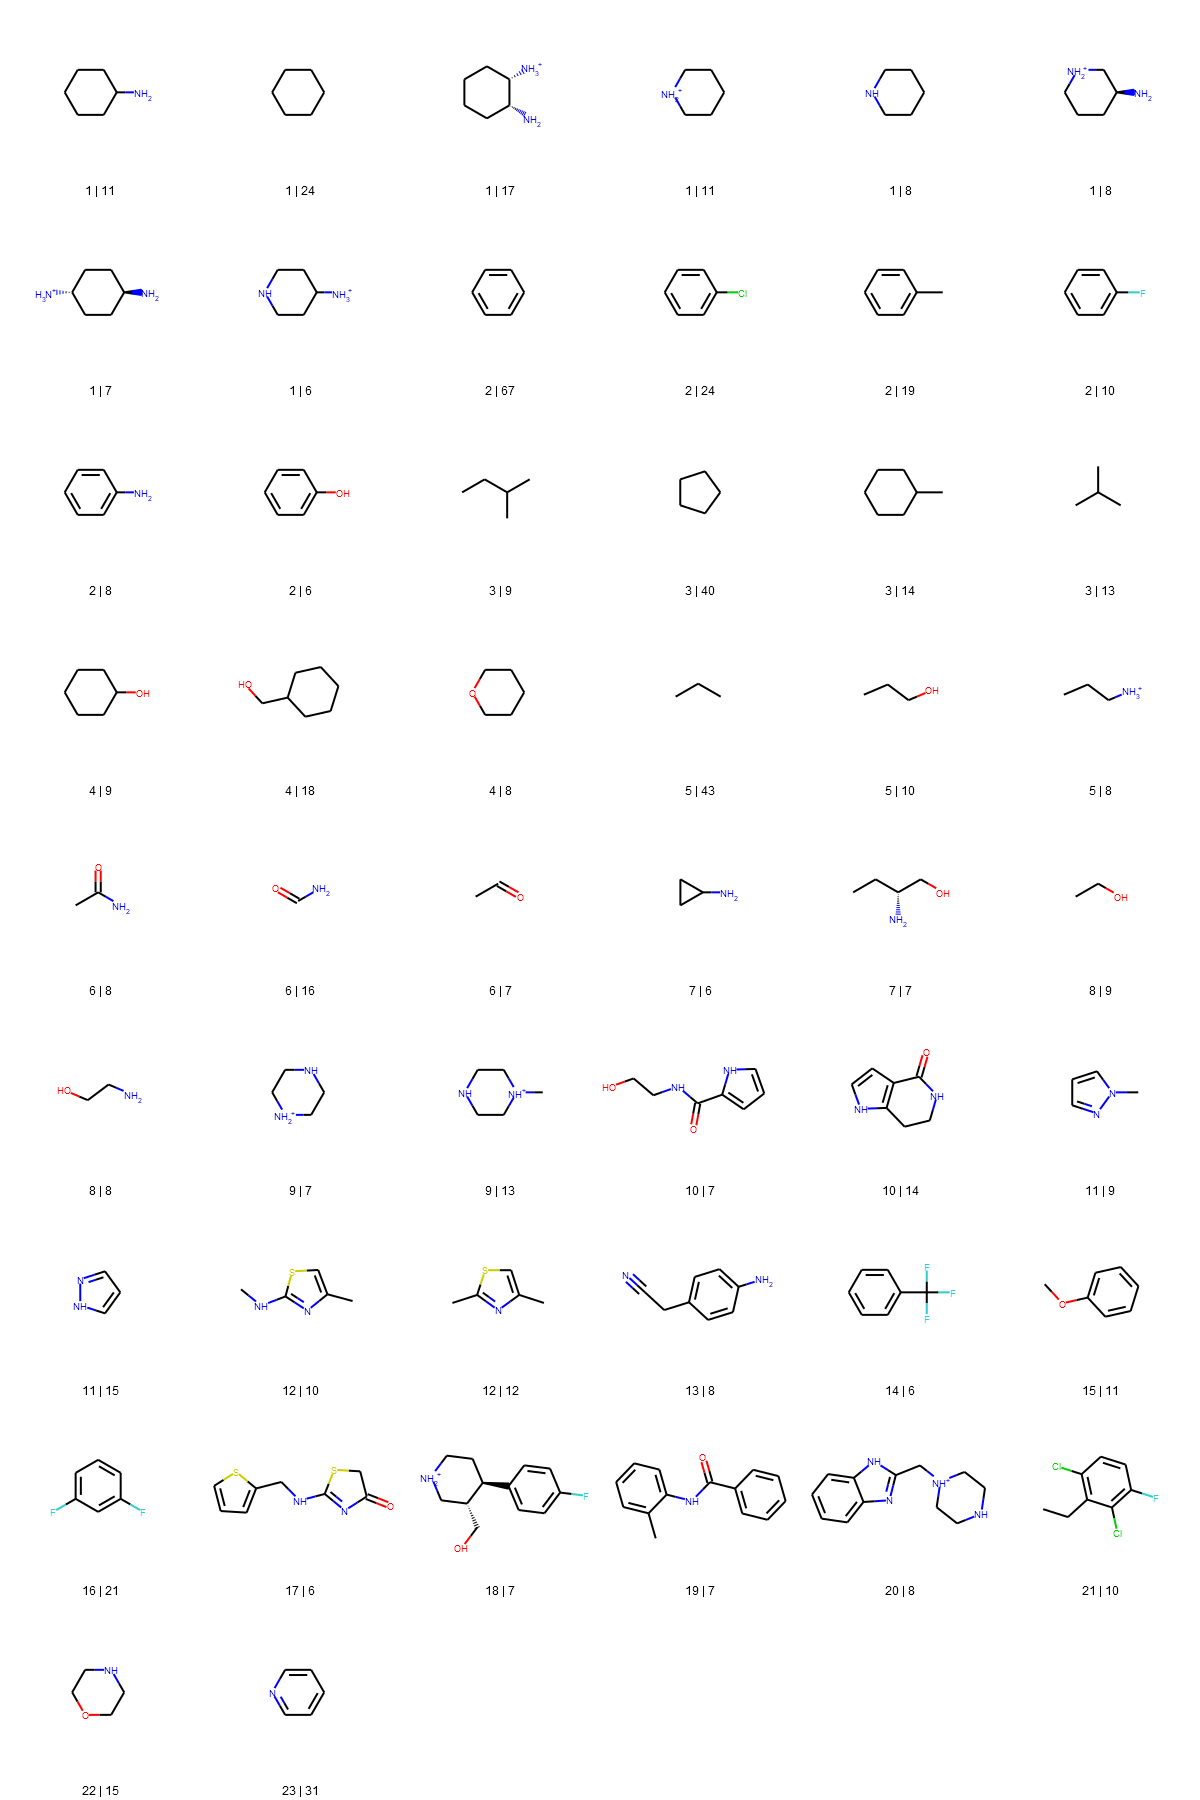

In [7]:
main(fragment_library, 'FP')

### Solvent-exposed pocket

Number of fragments: 50
Threshold:  0.6
Number of clusters:  23
# clusters with only 1 compound:  11
<class 'PIL.PngImagePlugin.PngImageFile'>


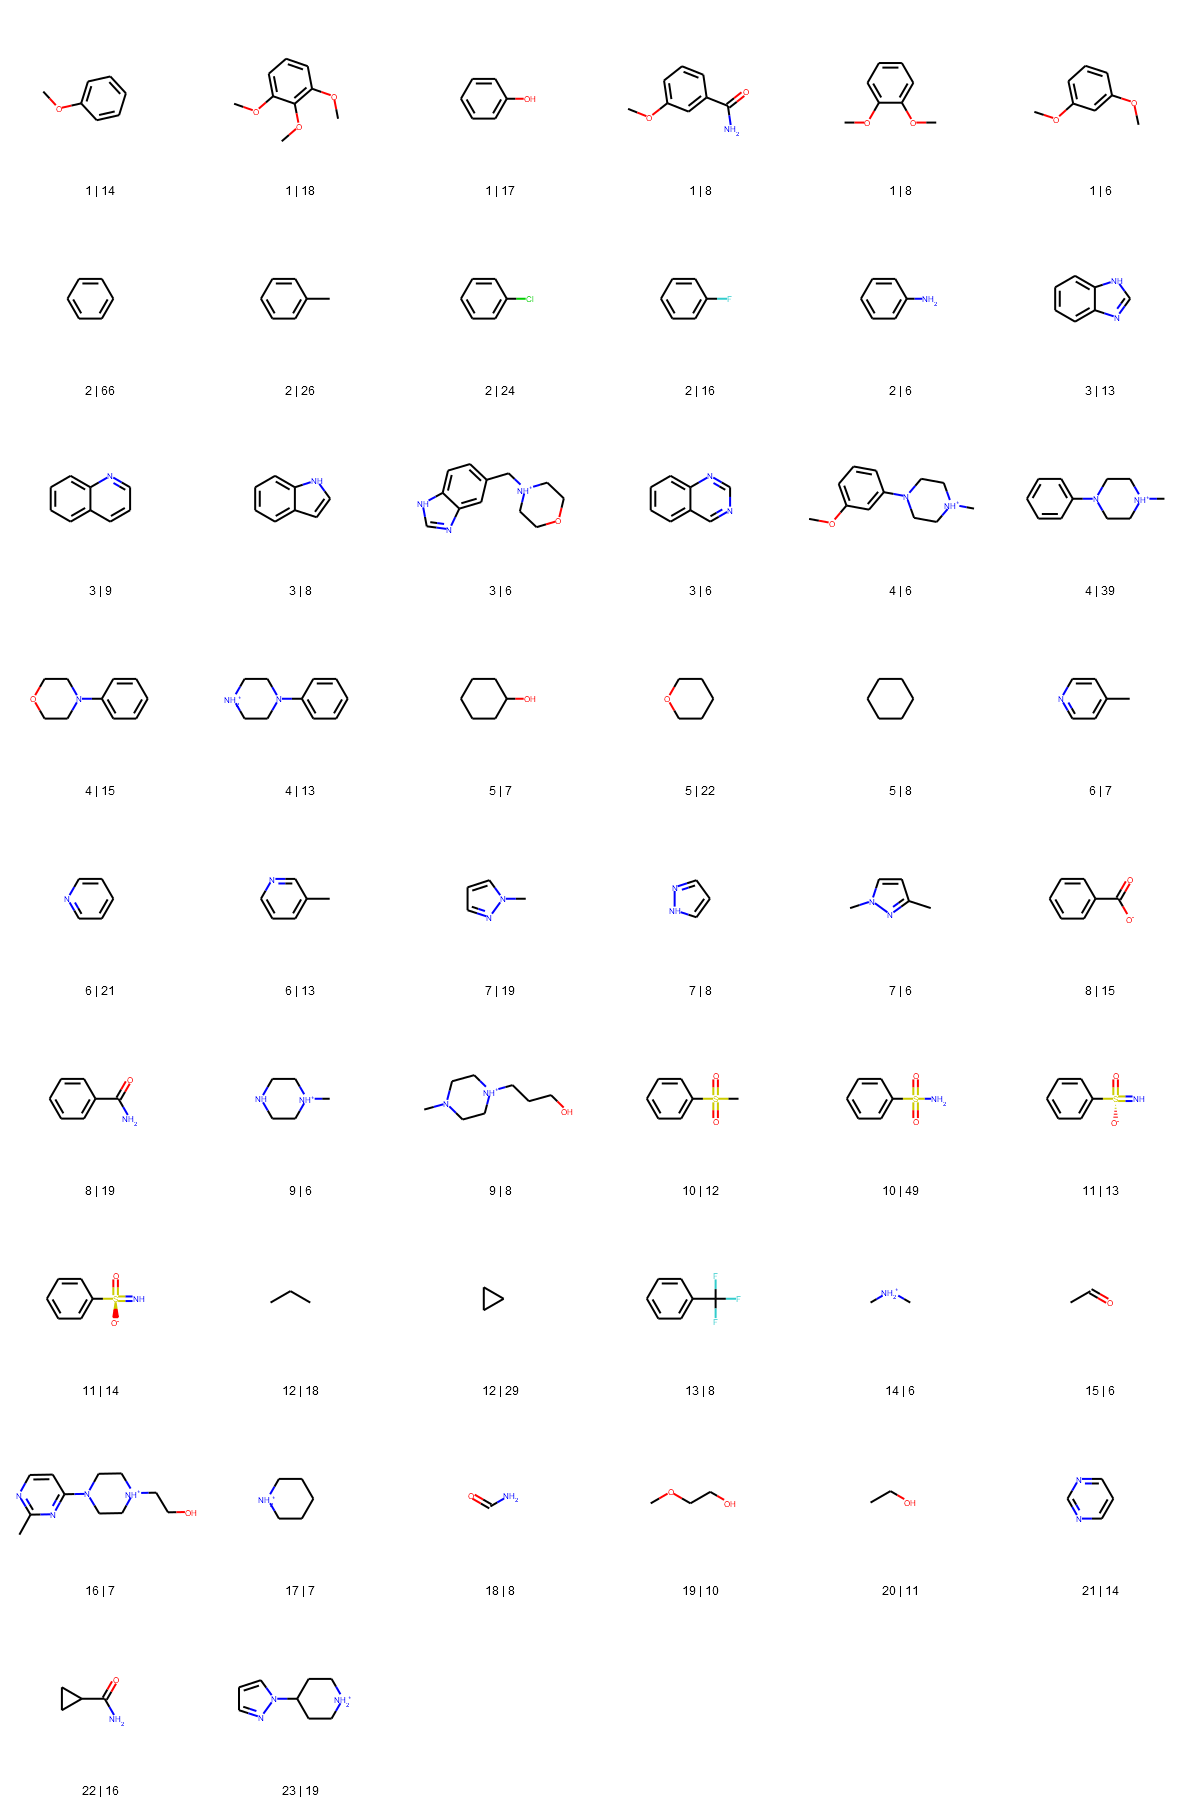

In [8]:
main(fragment_library, 'SE')

### Gate area

Number of fragments: 50
Threshold:  0.6
Number of clusters:  20
# clusters with only 1 compound:  11
<class 'PIL.PngImagePlugin.PngImageFile'>


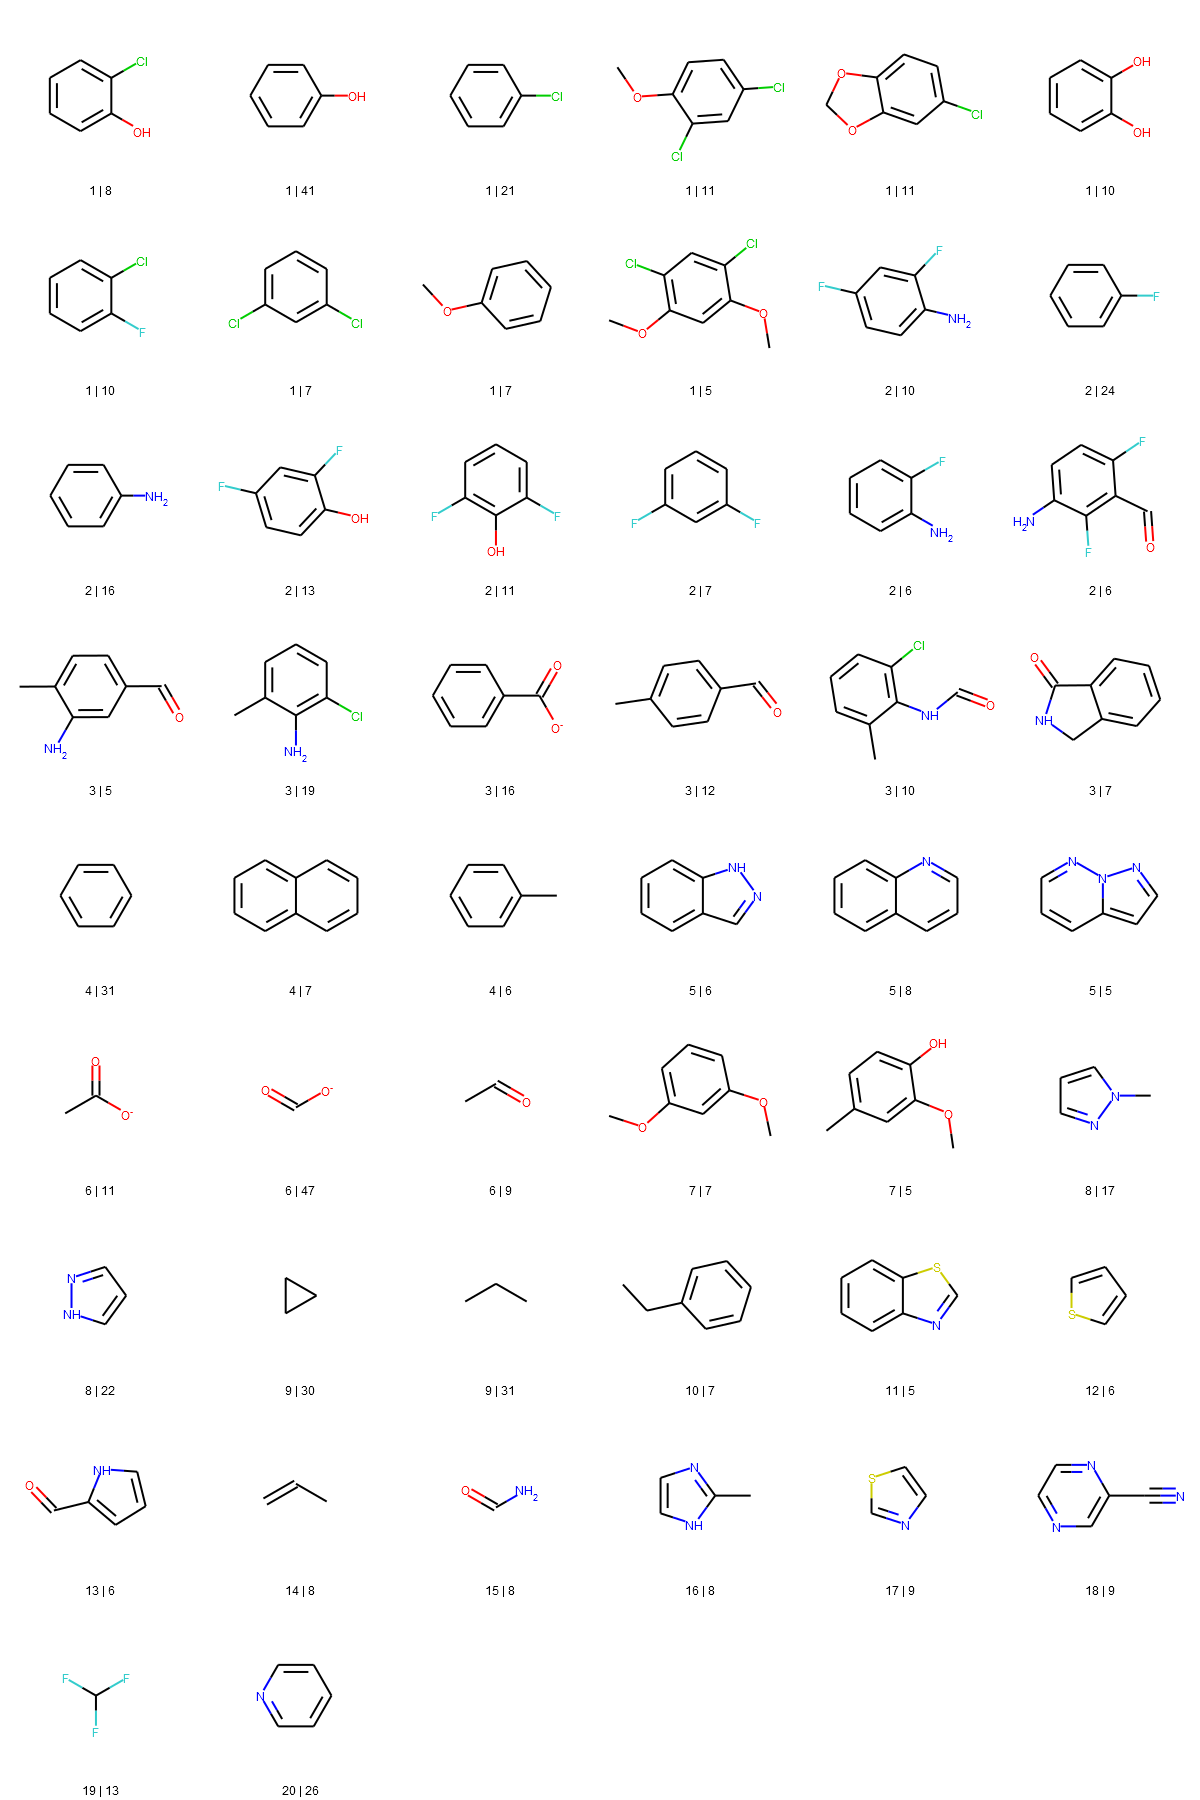

In [9]:
main(fragment_library, 'GA')

### Back pocket I

Number of fragments: 42
Threshold:  0.6
Number of clusters:  25
# clusters with only 1 compound:  17
<class 'PIL.PngImagePlugin.PngImageFile'>


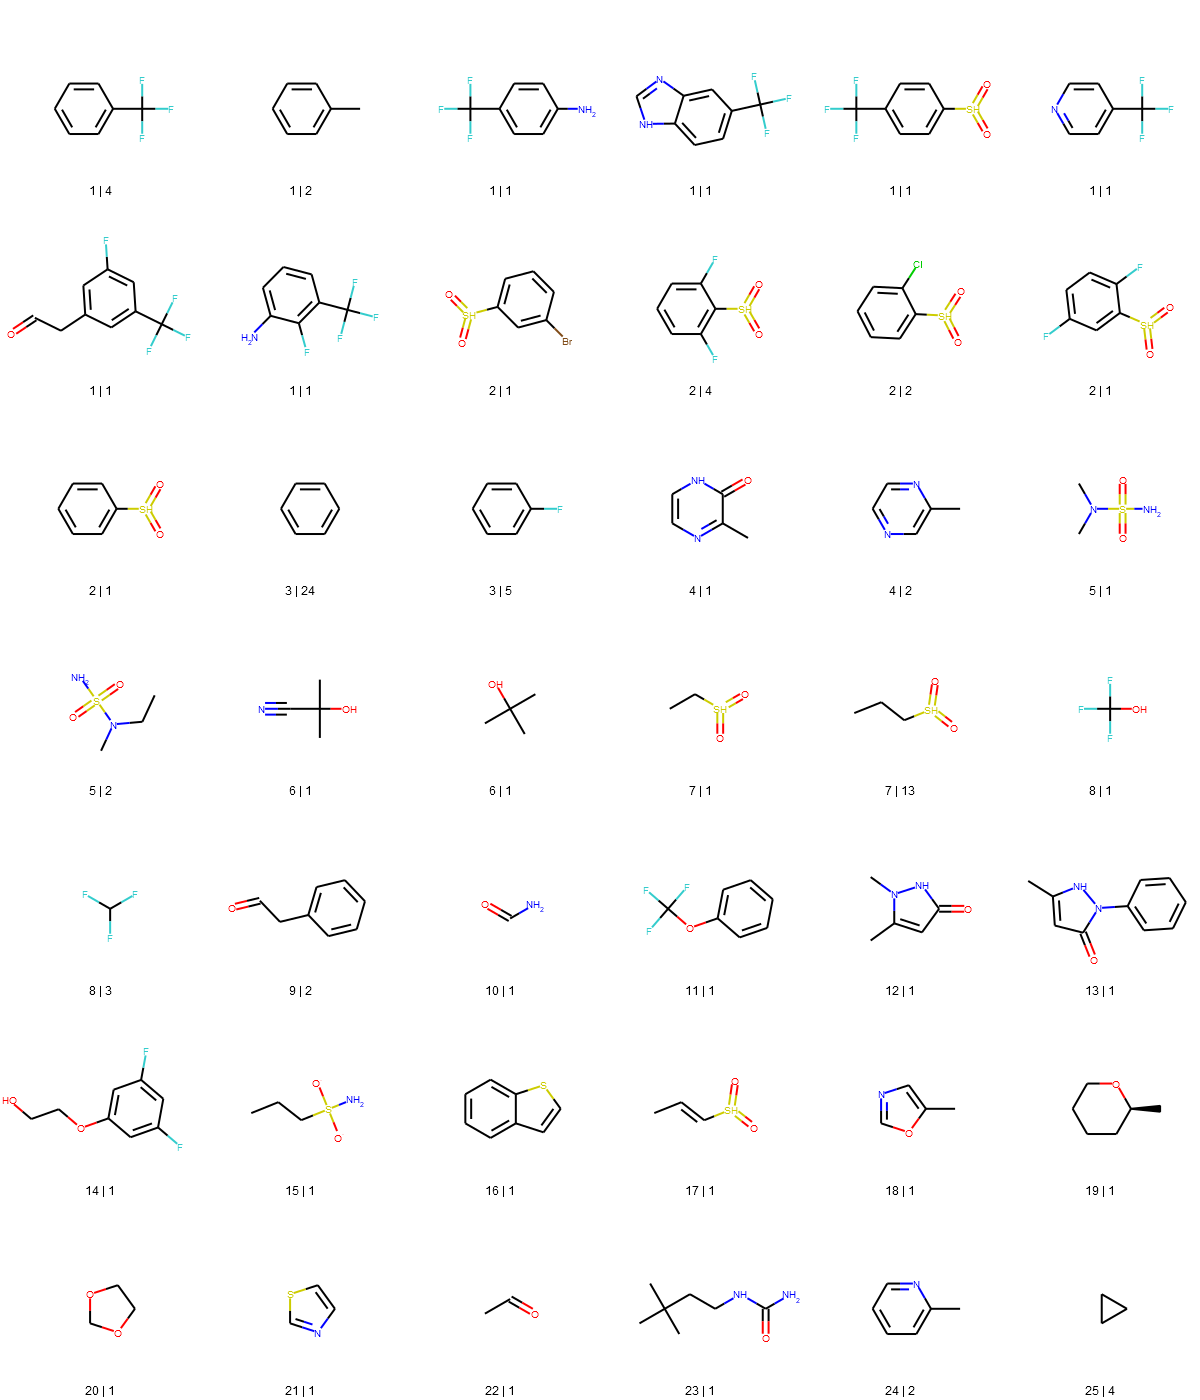

In [10]:
main(fragment_library, 'B1')

### Back pocket II

Number of fragments: 43
Threshold:  0.6
Number of clusters:  30
# clusters with only 1 compound:  24
<class 'PIL.PngImagePlugin.PngImageFile'>


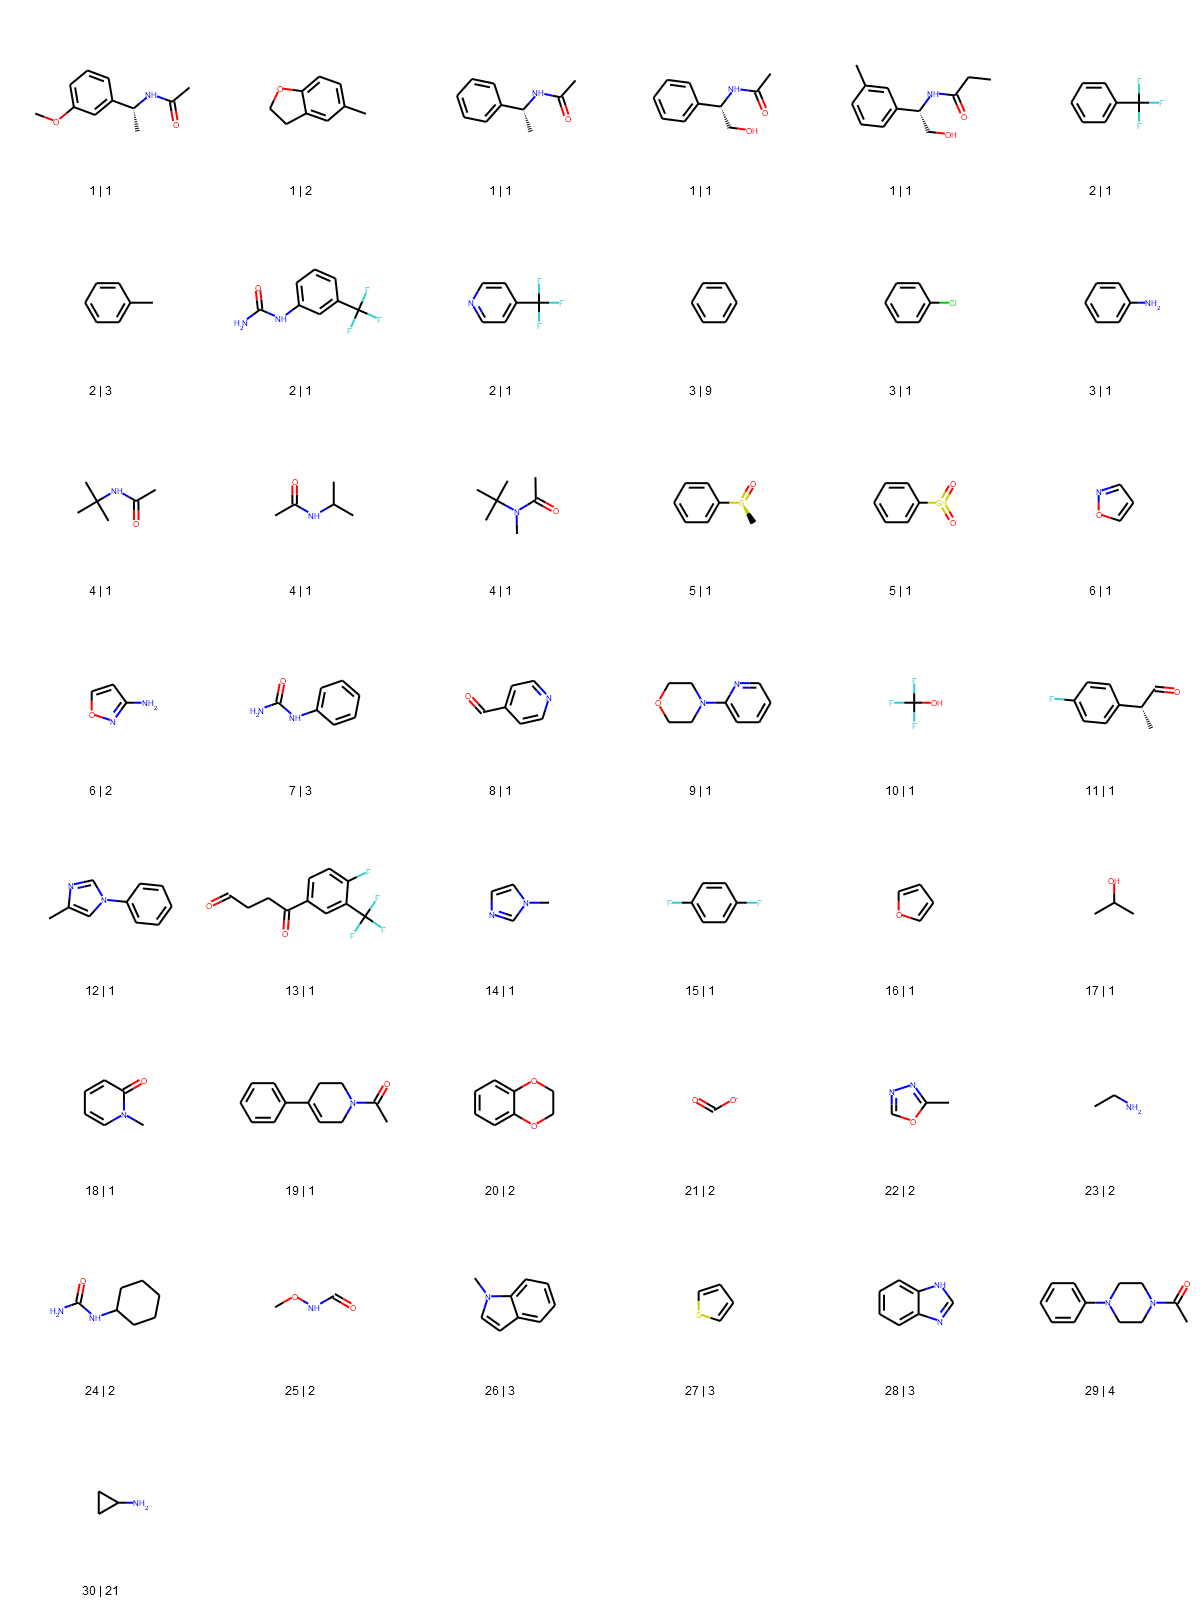

In [11]:
main(fragment_library, 'B2')